# Sentiment Analysis of Twitter Data

### installing required libraries
twint library used for colliction data from twitter without API.

In [1]:
!pip install twint
!pip install --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
#this prevents async problems/ runtime errors
!pip install nest_asyncio

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 kB 656.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.3/385.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.4 MB/s eta 0:00:00
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33929 sha256=d094230aa05edde1293f5a331d158f650b683b16fcc9c6933f39d85de847ad09
  Stored in directory: /root/.cache/pip/wheels/44/fc/77/99887a36b5c265a87516158858697d1a0b8f32c4d4dbddbb24
  Created wheel for googletransx: filename=googletransx-2.4.2-py3-none-any.whl size=15968 sha256=fda06284cf70cb169939ee220fa5a8740b32fc917ce4cf672da0dcfa483f9280
  Stored 

### import required libraries

In [2]:
import twint
import nest_asyncio
nest_asyncio.apply()
import json
import re
from nltk import ngrams
import csv
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for plot styling

### Collection data
Instantiate and configure the twint-object for get data from twitter.


In [3]:
c = twint.Config()
c.Store_object = True
c.Pandas =True
c.Search = "#سياحة"
# c.Since = '2022-01-01'
# c.Until = '2022-11-30'
c.Limit = 100
c.Lang = 'ar'
c.Filter_retweets = False
c.Store_json = True
c.Output = "1_tweets.json"
twint.run.Search(c)
# Quick check
# twint.storage.panda.Tweets_df.head(20)

1603865877945802752 2022-12-16 21:33:18 +0000 <pro_travel1> جورجيا  أستمتع بأحلي الأماكن لل السياحة في جورجيا وكمان هنعرفك علي الأستثمار في جورجيا اتصل علي :00995596355000  #سياحة #دبي  https://t.co/1hc1so8akg
1603862185150644225 2022-12-16 21:18:37 +0000 <georgiatours6> جورجيا  ✅Tours all over Georgia  ✅Private Cars 🚗   ✅ Hotels / Apartments Reservation 📞 WhatsApp   https://t.co/ypacQ4XC0R.  #سياحة  https://t.co/UFpPyaJbqR
1603859676466233346 2022-12-16 21:08:39 +0000 <safari_news> استمتع بعروض وفعاليات جزيرة فيلا الخاصة في #المالديف   https://t.co/jk8rvjvKQ0  #فنادق #سياحة  https://t.co/aJg7hqs0dY
1603859314304761859 2022-12-16 21:07:13 +0000 <Dam_xnl> #سفير_امستردام  #سياحة   عروض سياحية  امستردام &amp; بروكسل  https://t.co/IzbGSVvcwk
1603859188848943111 2022-12-16 21:06:43 +0000 <Dam_xnl> #سفير_امستردام  #سياحة   عروض سياحية  امستردام &amp; بروج  https://t.co/mb94TkOdX6
1603859066455040001 2022-12-16 21:06:14 +0000 <Dam_xnl> #سفير_امستردام  #سياحة   عروض سياحية  #باريس  https://t.c

## 1- Loading and Cleaning Twitter Data

In [4]:
# Open the input file
input_file = open('/kaggle/input/sentiment-arabic-tweets/1_tweets.json','r', encoding="utf-8")
clean_tweets = open('/kaggle/working/clean_tweets.txt','w', encoding="utf-8")


# Load the first few lines
for line in input_file:
    tweet = json.loads(line)
    temp = re.sub("@[A-Za-z0-9_]+","@User", tweet['tweet'])
    temp = re.sub(r"http\S+", "URL", temp)
    temp = re.sub(r"www.\S+", "URL", temp)
    temp = re.sub('[()!\'?]', '', temp)
    temp = re.sub('\[.*?\]','', temp)
    temp = re.sub("[^أ-يA-z0-9@]"," ", temp)
    clean_tweets.write(temp + '\n')

# Close the input files
input_file.close()
clean_tweets.close()

## 2- Derive the sentiment of each tweet

put the lexicon/Afinn file in dict as {term:score}

In [5]:
afinnfile = open("/kaggle/input/sentiment-arabic-tweets/3_Afinne_arabic.csv", 'r', encoding="utf-8")
scores = {} # initialize an empty dictionary
for line in afinnfile:
    line = line.strip()
    term = line.split(',')[0]
    score = line.split(',')[1]
    try:
        scores[term] = float(score) # Conver the score to an integer. It was parsed as a string.
    except:
        None
afinnfile.close()
print(len(scores))
# print(scores.items( )) # Print every (term, score) pair in the dictionary

42772


- make score for each tweets in sentiment file
- make newWords dectionary for words that not exist in clean_tweets file

In [6]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
sentiments = open("/kaggle/working/3_sentiment.txt", 'w', encoding="utf-8")
newWords = {}
for line in tweets:
    line = line.strip()
    total_score = 0
    for word in line.split(' '):
        wordScore = scores.get(word, 0)
        total_score = total_score + wordScore
        if wordScore == 0 and word != 'URL' and word != 'User':
            newWords[word] = newWords.get(word, 0)
    sentiments.write(str(round(total_score, 3)) + "\n")        
tweets.close()
sentiments.close()
print(len(newWords))

3573


give score for new words in newWords dictionary

In [7]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
sentiments = open("/kaggle/working/3_sentiment.txt", 'r', encoding="utf-8")
result = open("/kaggle/working/3_stdout.txt", 'w', encoding="utf-8")

tweets_scores = sentiments.read().split('\n')
word_score = None
for word in newWords.keys():
    word_score = 0
    index = 0
    for line in tweets:
        line = line.split(' ')
        if word in line:
            word_score += float(tweets_scores[index].strip())
        index += 1
    if word_score > 0:
        newWords[word] = 1
    elif word_score < 0:
        newWords[word] = -1
    else:
        newWords[word] = 0
    result.write(word +' '+ str(newWords[word]) +'\n')
    tweets.seek(0)
tweets.close()
# print(newWords)

## feature extraction
- N-grams are continuous sequences of words or symbols or tokens in a document.
- They come into play when we deal with text data in NLP(Natural Language Processing) tasks.
- من البيانات التي قمنا بإنشائها وتصفيتها feature نعمل هنا على استخراج ال 

In [8]:
tweets = open("/kaggle/working/clean_tweets.txt", 'r', encoding="utf-8")
afinnfile = open("/kaggle/input/sentiment-arabic-tweets/3_Afinne_arabic.csv", 'r', encoding="utf-8")
f = open("/kaggle/working/featuresAndLabels.csv", 'w',newline='',encoding='utf-8-sig')
writer = csv.writer(f)

scores = {} # initialize an empty dictionary
for line in afinnfile:
    line = line.strip()
    term = line.split(',')[0]
    score = line.split(',')[1]
    try:
        scores[term] = float(score) # Conver the score to an integer. It was parsed as a string.
    except:
        None
afinnfile.close()

# Function to extract lexicon items
def extract(g, lex):
    if ' '.join(g) in lex.keys():
        return lex.get(' '.join(g))
    elif g[0] in lex.keys():
        return lex.get(g[0])
    else:
        pass

# Your task
mylist = list()
mylist.append(['tweet', 'feature'])
for line in tweets:
    line = line.strip()
    out = [extract(g, scores) for g in ngrams(line.split(), 2) if extract(g, scores)]
    out = sum(out)
    if out > 0:
        mylist.append([line,"positive"])
    elif out < 0:
        mylist.append([line,"negative"])
    else:
        mylist.append([line,'neutral'])
writer.writerows(mylist)
tweets.close()
f.close()

## Training and Testing By SVM
-  للتأكد أن البيانات التي سنقوم بتدريبها صحيحة ،feature نقوم باستخدام بيانات جاهزة لاستخراج ال

In [9]:

df = pd.read_csv('/kaggle/input/sentiment-arabic-tweets/4_AT-ODTSA_Dataset_RawDataV1-1.csv')
X=df['tweet'].values
y=df['sentiment'].values


# Split the tweets into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['sentiment'], test_size=0.2)

# Convert the tweets into numerical features
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Train the SVM model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Test the model on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy score is {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy score is 0.57
              precision    recall  f1-score   support

          -1       0.53      0.46      0.49       183
           0       0.61      0.59      0.60       208
           1       0.57      0.66      0.61       209

    accuracy                           0.57       600
   macro avg       0.57      0.57      0.57       600
weighted avg       0.57      0.57      0.57       600



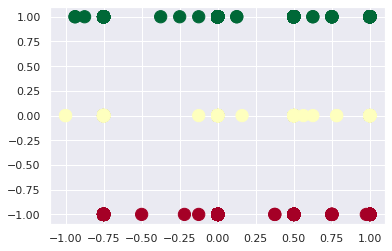

In [10]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
df['polarity'] = df['tweet'].apply(polarity)
X = df['polarity']
y = df['sentiment']
plt.scatter(X, y, c=y, s=150, cmap='RdYlGn')
